In [1]:
import os
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests
import warnings
warnings.filterwarnings('ignore')
z_dir="./z_each_weighted/"

column_to_analyze="NOS1"#"TNR"#"NOS1"#

In [2]:
def create_aggregated_dataframe(directory):
    aggregated_data = {}
    row_names = None

    # List all .csv files in the directory
    csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

    for file in csv_files:
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path, index_col=0)

        # Check if "all" column exists
        if column_to_analyze not in df.columns:
            raise ValueError(f'Column {column_to_analyze} not found in file {file}')

        # Convert Z-values to P-values (one-sided)
        p_values = norm.sf(df[column_to_analyze])

        # Adjust P-values (e.g., using Benjamini-Hochberg procedure)
        _, p_adjusted, _, _ = multipletests(p_values, method='fdr_bh')

        # Set Z-values to 0 where the adjusted P-values are > 0.05
        df[column_to_analyze] = df[column_to_analyze].where(p_adjusted <= 0.05, 0)
        
        # If row_names is not set yet, set it. Otherwise, check for consistency.
        if row_names is None:
            row_names = df.index.tolist()
        elif row_names != df.index.tolist():
            raise ValueError('Row names are not consistent across files.')

        # Add the adjusted 'all' column data to the aggregated_data with filename as key
        file_key = os.path.splitext(file)[0]  # Filename without .csv suffix
        aggregated_data[file_key] = df[column_to_analyze].tolist()

    # Create the final DataFrame and transpose it
    return pd.DataFrame(aggregated_data, index=row_names).T

In [3]:
meta_rank={
  "Overall AD neuropathological Change": {"Not AD": 1, "Low": 2, "Intermediate": 3, "High": 4},
  "Thal": {"Thal 0": 1, "Thal 1": 2, "Thal 2": 3, "Thal 3": 4, "Thal 4": 5, "Thal 5": 6},
  "Braak": {"Braak 0": 1, "Braak II": 2, "Braak III": 3, "Braak IV": 4, "Braak V": 5, "Braak VI": 6},
  "CERAD score": {"Absent": 1, "Sparse": 2, "Moderate": 3, "Frequent": 4},
  "Overall CAA Score": {"Not identified": 1, "Mild": 2, "Moderate": 3},
  "Highest Lewy Body Disease": {
    "Not Identified (olfactory bulb not assessed)": 1,
    "Not Identified (olfactory bulb assessed)": 2,
    "Olfactory bulb only": 3,
    "Brainstem-predominant": 4,
    "Limbic (Transitional)": 5,
    "Neocortical (Diffuse)": 6
  },
  "Atherosclerosis": {"None": 1, "Mild": 2, "Moderate": 3},
  "Arteriolosclerosis": {"Mild": 1, "Moderate": 2, "Severe": 3},
  "LATE": {"Not Identified": 1, "LATE Stage 1": 2, "LATE Stage 2": 3, "LATE Stage 3": 4},
  "Cognitive Status": {"No dementia": 1, "Dementia": 2}
}

In [4]:
# Assuming colocalize_df and metadata_df are defined globally
colocalize_df = create_aggregated_dataframe(z_dir)
colocalize_df=colocalize_df.loc[:, colocalize_df.sum() >= 3]
print(colocalize_df.shape)
metadata_df = pd.read_csv('metadata.csv', index_col=0)

common_samples=list(set(colocalize_df.index.tolist()).intersection(set(metadata_df.index.tolist())))
colocalize_df=colocalize_df.loc[common_samples,:]
metadata_df=metadata_df.loc[common_samples,:]

def replace_nan_with_none(df):
    for column in df.columns:
        # Check if the column is of type object (usually indicates a string)
        if df[column].dtype == object:
            df[column] = df[column].fillna("None")
    return df

metadata_df=replace_nan_with_none(metadata_df)

def convert_numeric_to_string(df):
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            df[column] = df[column].astype(str)
    return df

metadata_df=convert_numeric_to_string(metadata_df)

FileNotFoundError: [Errno 2] No such file or directory: './z_each_weighted/'

In [ ]:
def meta_str_to_number(metadata_df):
    df=pd.DataFrame()
    for metai in list(meta_rank.keys()):
        metadatai=metadata_df.loc[:,metai].values
        valuei=[]
        for j in range(len(metadatai)):
            valuei.append(meta_rank[metai][metadatai[j]])
        df[metai]=valuei
    return df

metanumber_df=meta_str_to_number(metadata_df)

In [ ]:
adata=sc.AnnData(colocalize_df.values)
for metai in meta_rank.keys():
    adata.obs[metai]=metadata_df[metai].values

In [ ]:
def plot_adata(adata,color):
    # Run PCA
    sc.tl.pca(adata, svd_solver='arpack')
    # Compute the neighbors graph
    sc.pp.neighbors(adata)

    # Compute UMAP
    sc.tl.umap(adata)

    # Plot UMAP
    sc.pl.umap(adata, color=color)

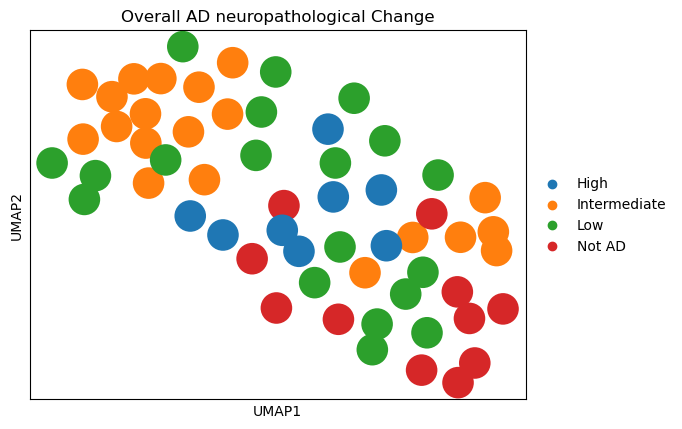

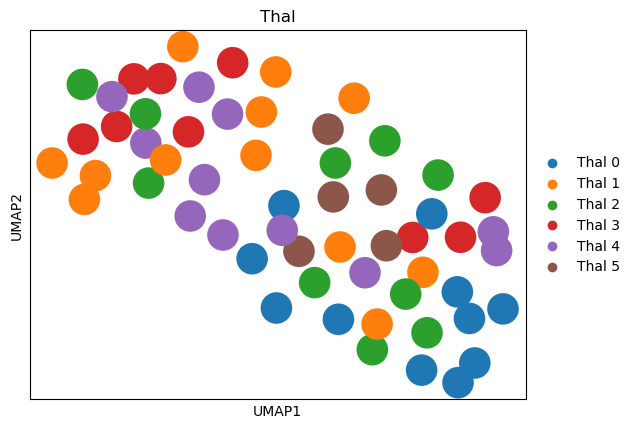

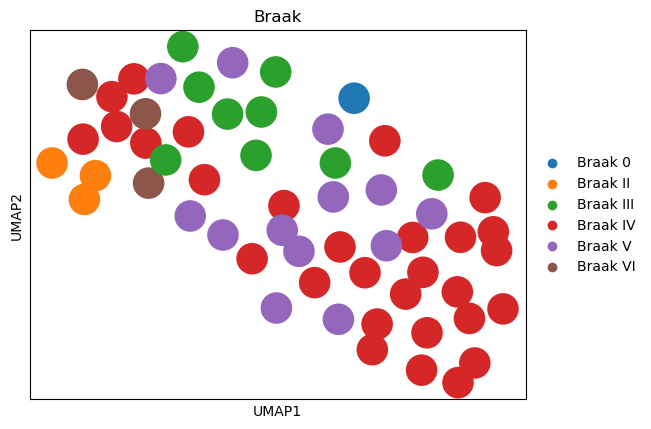

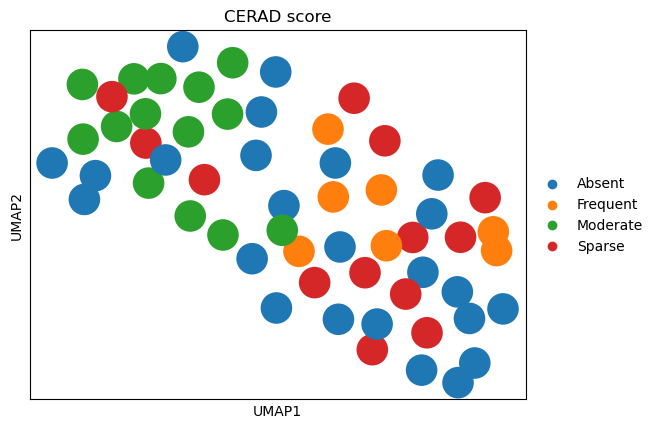

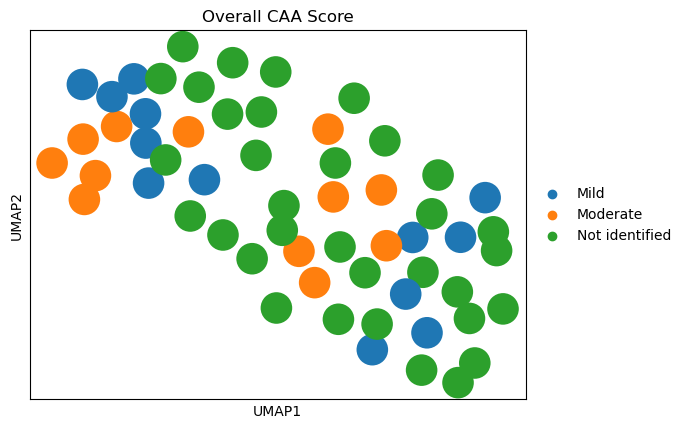

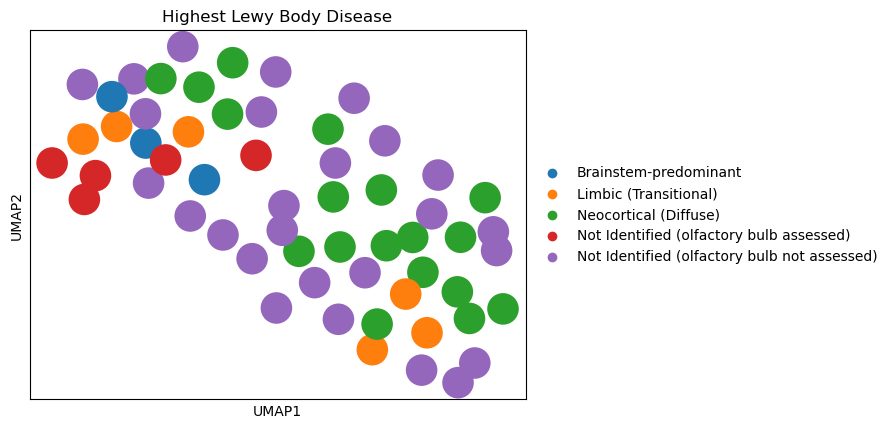

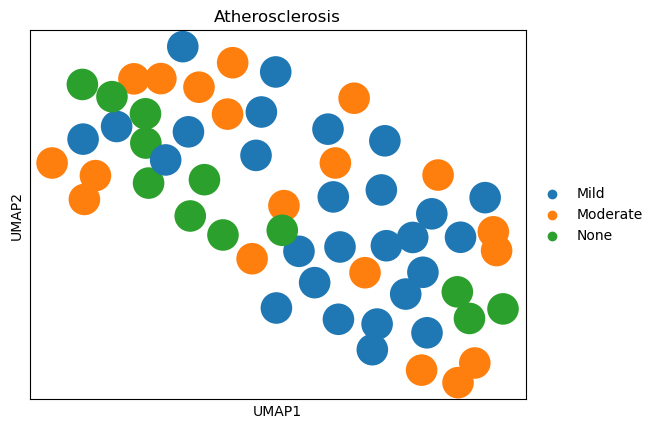

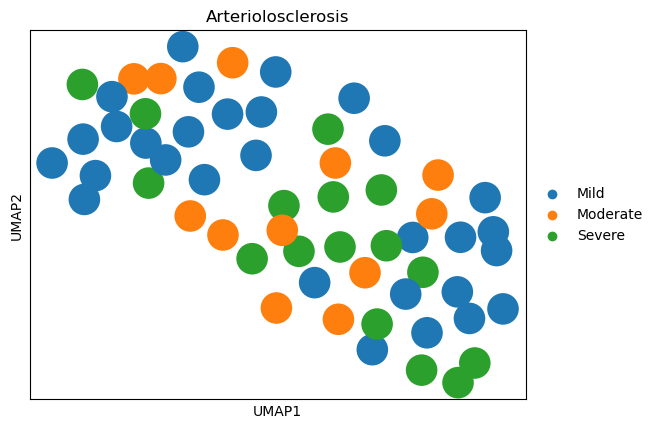

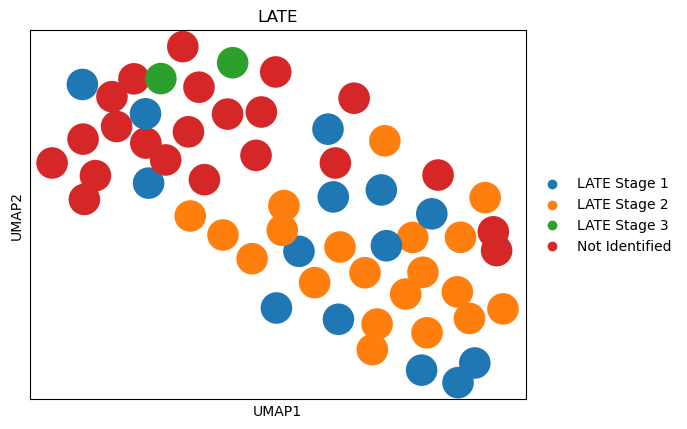

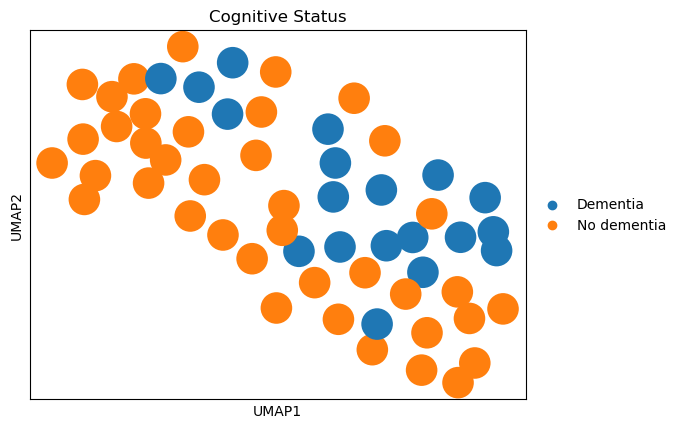

In [9]:
for metai in meta_rank.keys():
    plot_adata(adata,metai)

In [12]:
from scipy.stats import rankdata

def spearman_permutation_test(x, y, num_permutations=100000):
    # Calculate the ranks
    rx = rankdata(x)
    ry = rankdata(y)
    
    # Calculate the Spearman correlation coefficient
    n = len(x)
    d = np.sum((rx - ry) ** 2)
    rs = 1 - (6 * d) / (n * (n**2 - 1))
    
    # Permutation test to calculate the p-value
    count = 0
    for _ in range(num_permutations):
        np.random.shuffle(ry)  # Shuffle the ranks of y
        d_perm = np.sum((rx - ry) ** 2)
        rs_perm = 1 - (6 * d_perm) / (n * (n**2 - 1))
        if abs(rs_perm) >= abs(rs):
            count += 1
            
    p_value = count / num_permutations
    return rs, p_value

Cognitive Status
[1.         0.50462118 1.         1.         0.00288    0.72883938
 0.72883938 1.         1.         0.29008    1.         1.
 1.         1.         0.34569818 1.         1.         0.1143
 0.12068571 0.00288    0.97142049 0.34569818 1.         1.
 0.50462118 0.05928    0.02268    1.         1.         0.29008
 1.         0.50462118 0.34757217 1.         0.93484    1.
 1.         1.         0.12068571 0.86933408 1.         0.33677538
 0.28869818 0.75279273 0.72883938 0.97142049 0.1143     0.19018667
 0.19028571 0.34757217 1.         0.83036571 0.12068571 1.
 1.         1.         1.         1.         0.05928    0.25224
 0.97800289 1.         0.72883938 1.         1.         1.
 0.50967692 0.33677538 0.78671284 0.14995636 0.05928    1.
 0.72883938 0.12068571 0.97142049 1.         0.72883938 0.05928
 1.         0.72883938 0.29008    0.09339429 0.97142049 0.267615
 0.042336   0.05928    0.97142049 0.21982345 0.05832    1.
 1.         0.18315692 0.83036571 1.         1.  

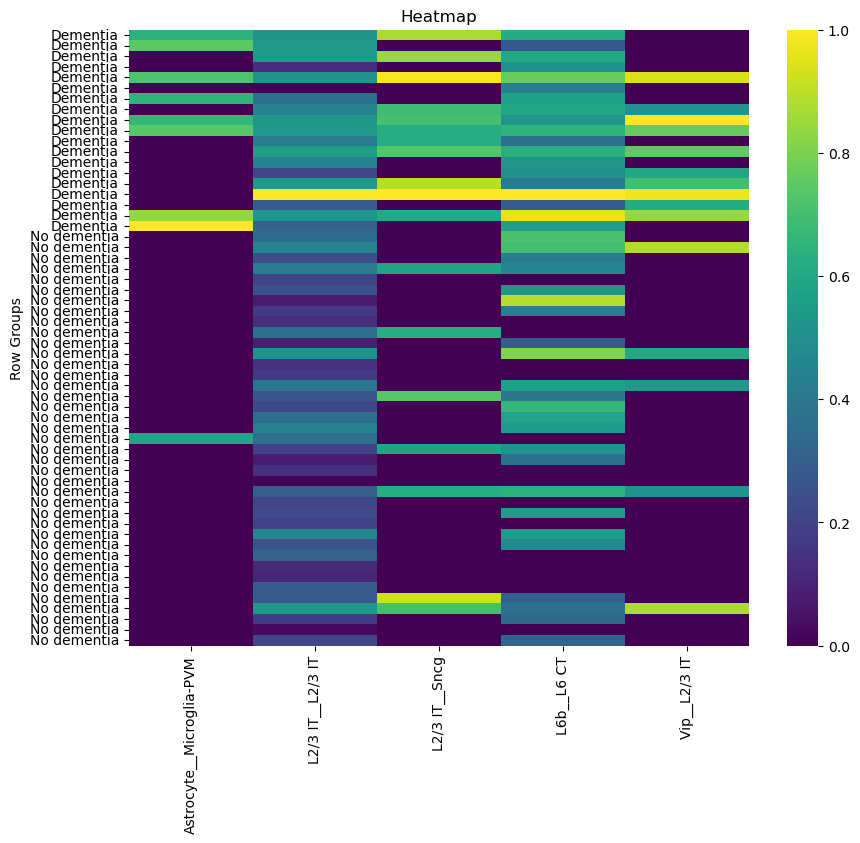

LATE
[0.301896   0.34726154 0.14466857 0.34726154 0.63866182 0.93384
 0.95390118 0.14466857 0.75596612 0.31232348 1.         1.
 1.         1.         1.         0.93384    1.         0.42858581
 0.93384    0.403392   1.         0.95390118 0.01686857 1.
 0.21934588 0.31232348 0.37872    0.301896   0.99205029 0.026928
 1.         1.         0.00504    0.32721702 1.         1.
 1.         0.35984571 0.99786566 0.21934588 0.09216    0.35282667
 0.058464   0.34726154 0.93384    1.         0.94312577 0.70296289
 0.05749714 0.04785231 0.21934588 0.67214466 0.67214466 0.35146868
 1.         1.         1.         0.1381824  0.99205029 0.63866182
 0.67214466 0.01686857 0.011232   0.75596612 1.         0.67723902
 0.0414     0.011232   0.67723902 0.06776471 0.10054957 0.21934588
 0.02893091 0.301896   0.99205029 0.197088   0.67723902 0.08420571
 1.         0.79171535 0.0248     0.072      0.44096    1.
 0.25389257 0.25604    0.67214466 0.00576    0.31232348 1.
 0.00504    1.         0.67214466 0

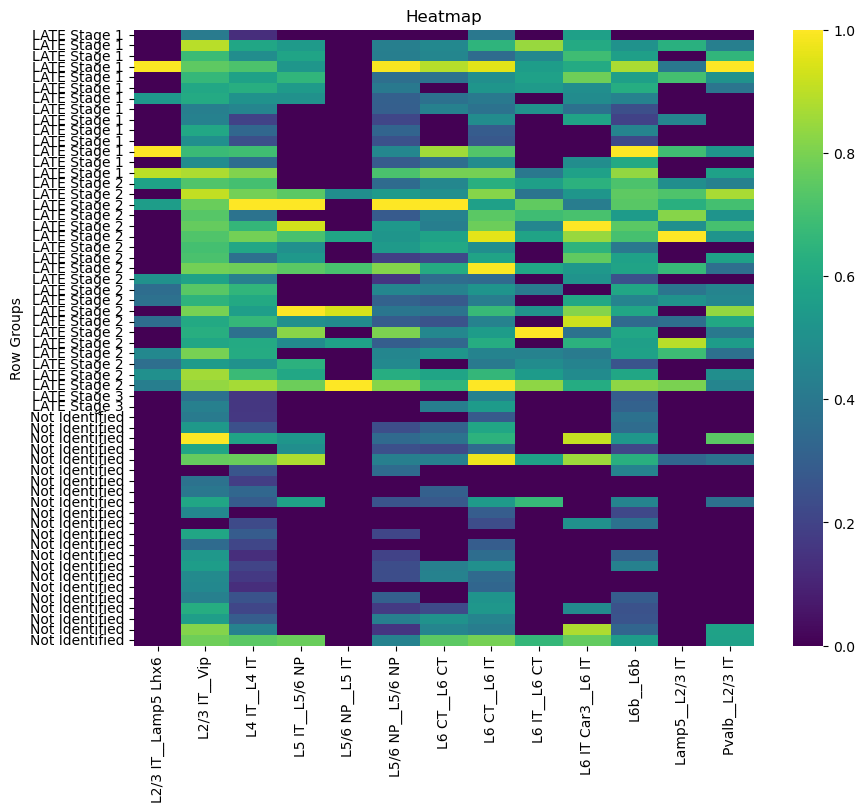

Arteriolosclerosis
[0.10944    1.         1.         1.         1.         0.94517581
 1.         1.         0.94517581 0.699936   1.         1.
 1.         1.         1.         1.         1.         1.
 0.94517581 0.80556    0.94517581 1.         0.08064    1.
 1.         0.53424    0.758016   1.         1.         0.94517581
 1.         0.86704    0.61395429 1.         1.         1.
 1.         1.         1.         0.53424    0.53424    1.
 0.758016   1.         0.94517581 1.         0.54243692 1.
 1.         1.         1.         1.         1.         0.758016
 1.         1.         1.         0.94517581 1.         1.
 1.         1.         0.92386286 1.         1.         0.94517581
 1.         1.         1.         1.         0.758016   1.
 1.         0.54243692 1.         1.         1.         0.53424
 1.         0.85779692 0.53424    0.54243692 1.         0.94517581
 0.94517581 1.         1.         0.80556    0.94517581 1.
 1.         1.         1.         1.         1.      

In [ ]:
from statsmodels.stats.multitest import multipletests
interactions=np.array(colocalize_df.columns.tolist())

import seaborn as sns
import matplotlib.pyplot as plt

def plot_grouped_heatmap(df, metadata, title='Heatmap', cmap='viridis'):
    # Step 1: Attach metadata to the dataframe
    if not isinstance(metadata, pd.Series):
        metadata = pd.Series(metadata, index=df.index)
    
    # Combine the metadata with the dataframe to sort
    combined = df.copy()
    combined['Metadata'] = metadata
    
    # Sort by metadata
    combined.sort_values('Metadata', inplace=True)
    
    # Remove the metadata column for plotting
    metadata_sorted = combined['Metadata']
    combined.drop(columns=['Metadata'], inplace=True)
    
    # Normalize each column to [0, 1]
    combined = (combined - combined.min()) / (combined.max() - combined.min())

    # Step 2: Create the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(combined, cmap=cmap, yticklabels=metadata_sorted)
    
    # Step 3: Enhance the plot
    plt.title(title)
    plt.ylabel('Row Groups')
    plt.show()

cutoff=0.05

for metai in list(reversed(list(meta_rank.keys()))):
    print(metai)
    p_values=[]
    scc=[]
    for interaction_namei in colocalize_df.columns.tolist():
        metadatai=metanumber_df[metai]
        interactioni=colocalize_df.loc[:,interaction_namei]
        scci,pi=spearman_permutation_test(metadatai,interactioni)
        p_values.append(pi)
        scc.append(scci)
    _, p_values, _, _ = multipletests(np.array(p_values), method='fdr_bh')
    print(p_values)
    if np.sum(p_values<cutoff)>0:
         print(metai,":",interactions[p_values<cutoff])
         if np.sum(p_values<cutoff)>=4:
             plot_grouped_heatmap(colocalize_df.loc[:,interactions[p_values<cutoff]],metadata_df[metai].values)
    else:
        print("No significant spearman correlation for",metai)